In [1]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install easyocr

Looking in indexes: https://download.pytorch.org/whl/cu118
  Using cached https://download.pytorch.org/whl/cu118/torchaudio-2.6.0%2Bcu118-cp312-cp312-win_amd64.whl.metadata (6.8 kB)
  Using cached https://download.pytorch.org/whl/cu118/torch-2.6.0%2Bcu118-cp312-cp312-win_amd64.whl.metadata (28 kB)
   ---------------------------------------- 0.0/4.0 MB ? eta -:--:--
   ----- ---------------------------------- 0.5/4.0 MB 3.3 MB/s eta 0:00:02
   -------------------- ------------------- 2.1/4.0 MB 3.7 MB/s eta 0:00:01
   ------------------------------- -------- 3.1/4.0 MB 4.2 MB/s eta 0:00:01
   -------------------------------------- - 3.9/4.0 MB 4.3 MB/s eta 0:00:01
   -------------------------------------- - 3.9/4.0 MB 4.3 MB/s eta 0:00:01
   ---------------------------------------- 4.0/4.0 MB 3.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.7 GB ? eta -:--:--
   ---------------------------------------- 0.0/2.7 GB 4.8 MB/s eta 0:09:33
   ----------------------------

In [17]:
import easyocr
import cv2
from matplotlib import pyplot as plt
import os
import random
from scipy.ndimage import rotate
import numpy as np

In [94]:
folder_path = os.path.join("..", "Plot QA Dataset", "train", "png")

image_files = [f for f in os.listdir(folder_path) if f.endswith('.png')]

random_image = random.choice(image_files)

image_path = os.path.join(folder_path, random_image)

In [95]:
reader = easyocr.Reader(['en'], gpu=False)

Using CPU. Note: This module is much faster with a GPU.


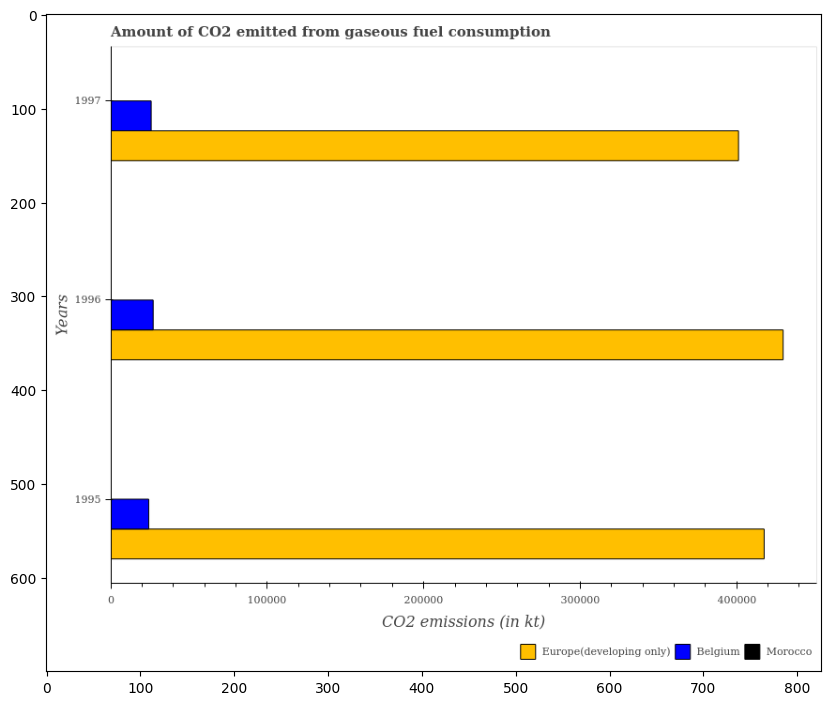

In [96]:
img = cv2.imread(image_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10,10))
plt.imshow(img)
plt.show()

In [97]:
def is_vertical(bbox):
    """Check if a bounding box is vertical based on its height-to-width ratio."""
    (top_left, top_right, bottom_right, bottom_left) = bbox
    width = np.linalg.norm(np.array(top_right) - np.array(top_left))
    height = np.linalg.norm(np.array(top_left) - np.array(bottom_left))

    return height > width

In [98]:
def extract_and_rotate(image, bbox):
    """Extracts a bounding box region, rotates it counterclockwise, and enhances quality."""
    (top_left, top_right, bottom_right, bottom_left) = bbox
    x_min = int(min(top_left[0], bottom_left[0]))
    x_max = int(max(top_right[0], bottom_right[0]))
    y_min = int(min(top_left[1], top_right[1]))
    y_max = int(max(bottom_left[1], bottom_right[1]))

    cropped = image[y_min:y_max, x_min:x_max]

    if cropped.size == 0:
        return None  # Skip empty regions

    # Rotate the cropped text region counterclockwise
    rotated = rotate(cropped, 90, reshape=True)

    # Enhance quality before OCR
    enhanced = enhance_image(rotated)

    return enhanced

In [99]:
def enhance_image(image):
    """Enhances image quality by applying sharpening, denoising, and contrast adjustment."""
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply sharpening
    sharpen_kernel = np.array([[0, -1, 0],
                               [-1,  5, -1],
                               [0, -1, 0]])
    sharp = cv2.filter2D(gray, -1, sharpen_kernel)

    # Apply denoising
    denoised = cv2.fastNlMeansDenoising(sharp, None, 30, 7, 21)

    # Apply contrast enhancement
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    enhanced = clahe.apply(denoised)

    return enhanced

In [100]:
def is_text_upside_down(image):
    """Checks if text is upside down by comparing OCR confidence."""
    result_normal = reader.readtext(image)
    flipped = cv2.flip(image, -1)  # Flip upside down
    result_flipped = reader.readtext(flipped)

    # Calculate total confidence
    conf_normal = sum([conf for (_, _, conf) in result_normal])
    conf_flipped = sum([conf for (_, _, conf) in result_flipped])

    return flipped if conf_flipped > conf_normal else image  # Use flipped if confidence is better

In [101]:
def detect_text_with_confidence(image):
    """Runs OCR twice: once normally, then with numbers-only if confidence is low."""
    # First OCR pass (normal)
    results = reader.readtext(image)

    # If any detection has low confidence, re-run OCR with numbers only
    improved_results = []
    for bbox, text, prob in results:
        if prob < 0.5:  # Confidence threshold (adjust as needed)
            number_results = reader.readtext(image, allowlist="0123456789")

            # If confidence improves, use the detected number
            for num_bbox, num_text, num_prob in number_results:
                if num_prob > prob:  # If new detection has higher confidence
                    text, prob = num_text, num_prob  # Replace text with better detection

        improved_results.append((bbox, text, prob))

    return improved_results

In [102]:
def process_image(image_path):
    """Detects text, rotates vertical text, enhances quality, corrects upside-down text, and extracts text."""
    image = cv2.imread(image_path)
    output_img = image.copy()  # Copy for drawing
    rotated_images = []  # Store rotated images for display

    # Step 1: Run EasyOCR
    results = detect_text_with_confidence(image)

    final_texts = []

    for bbox, text, prob in results:
        top_left = tuple(map(int, bbox[0]))
        bottom_right = tuple(map(int, bbox[2]))

        if is_vertical(bbox):
            rotated = extract_and_rotate(image, bbox)

            if rotated is not None:
                # Fix upside-down text
                corrected_image = is_text_upside_down(rotated)
                rotated_images.append(corrected_image)

                # Re-run OCR on the corrected image
                rotated_result = detect_text_with_confidence(corrected_image)

                for (_, rotated_text, rotated_prob) in rotated_result:
                    final_texts.append((rotated_text, rotated_prob, "vertical"))
                    text = rotated_text  # Update with corrected text

        else:
            final_texts.append((text, prob, "horizontal"))

        # Draw bounding boxes and text
        font = cv2.FONT_HERSHEY_SIMPLEX
        output_img = cv2.rectangle(output_img, top_left, bottom_right, (0, 255, 0), 3)  # Green box
        output_img = cv2.putText(output_img, text, (top_left[0], top_left[1] - 10), font, 0.8, (0, 255, 0), 2, cv2.LINE_AA)

    return final_texts, output_img, rotated_images

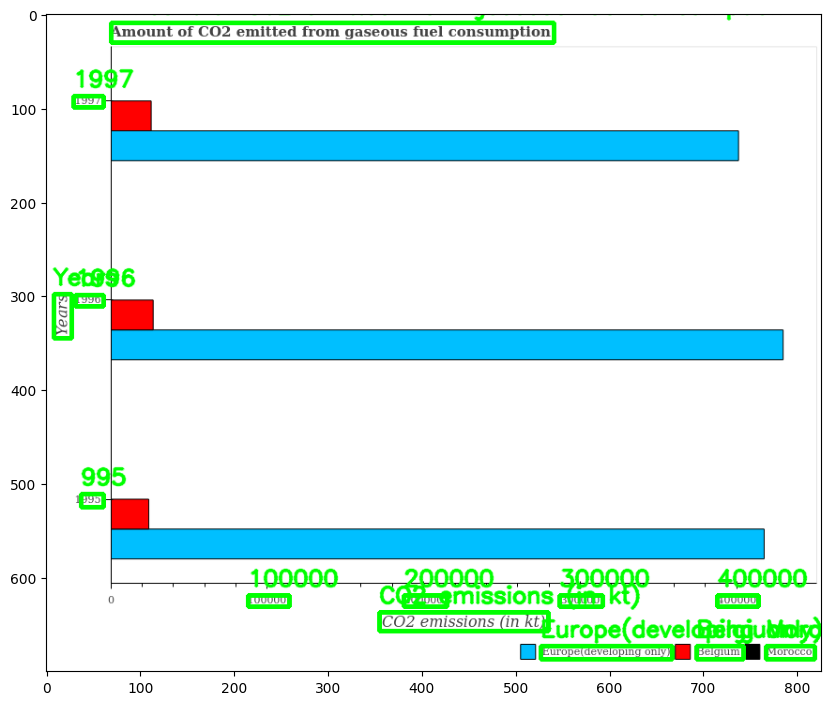

In [103]:
text_results, annotated_img, rotated_images = process_image(image_path)

# Show results
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB))
plt.show()

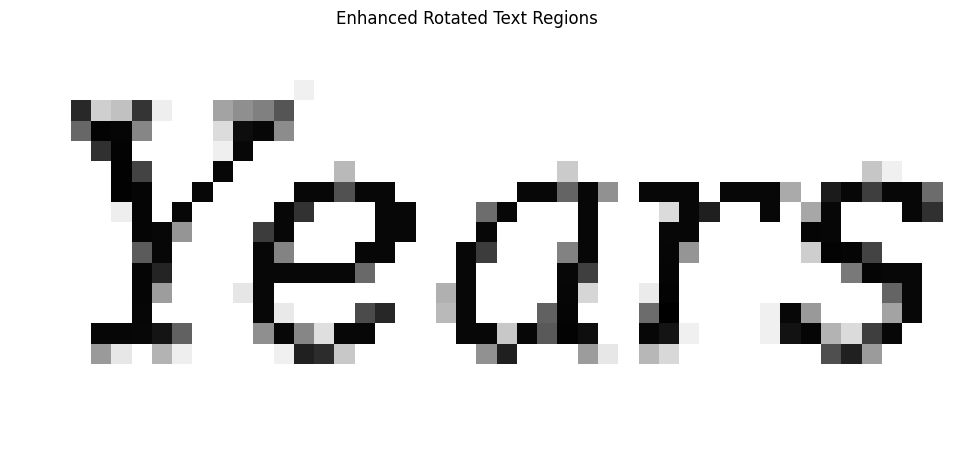

In [104]:
if rotated_images:
    fig, axes = plt.subplots(1, len(rotated_images), figsize=(15, 5))
    if len(rotated_images) == 1:
        axes = [axes]  # Ensure iterable
    for ax, img in zip(axes, rotated_images):
        ax.imshow(img, cmap="gray")
        ax.axis("off")
    plt.suptitle("Enhanced Rotated Text Regions")
    plt.show()

In [105]:
for text, prob, orientation in text_results:
    print(f"Detected {orientation} Text: {text} (Confidence: {prob:.2f})")

Detected horizontal Text: Amount of C02 emitted from gaseous fuel consumption (Confidence: 0.82)
Detected horizontal Text: 1997 (Confidence: 0.72)
Detected horizontal Text: 1996 (Confidence: 0.93)
Detected vertical Text: Years (Confidence: 1.00)
Detected horizontal Text: 995 (Confidence: 1.00)
Detected horizontal Text: 100000 (Confidence: 0.99)
Detected horizontal Text: 200000 (Confidence: 1.00)
Detected horizontal Text: 300000 (Confidence: 1.00)
Detected horizontal Text: 400000 (Confidence: 1.00)
Detected horizontal Text: CO2 emissions (in kt) (Confidence: 0.86)
Detected horizontal Text: Europe(developing only) (Confidence: 0.80)
Detected horizontal Text: Belgium (Confidence: 0.90)
Detected horizontal Text: Morocco (Confidence: 1.00)
